使用sklearn做各种回归

基本回归：线性、决策树、SVM、KNN

集成方法：随机森林、Adaboost、GradientBoosting、Bagging、ExtraTrees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
%matplotlib inline

为了实验用，写了一个二元函数，y=0.5*np.sin(x1)+ 0.5*np.cos(x2)+0.1*x1+3。其中x1的取值范围是0~50，x2的取值范围是-10~10，x1和x2的训练集一共有500个，测试集有100个。其中，在训练集的上加了一个-0.5~0.5的噪声。生成函数的代码如下：

In [2]:
def f(x1, x2):
    y = 0.5 * np.sin(x1) + 0.5 * np.cos(x2) + 3 + 0.1 * x1 
    return y

def load_data():
    x1_train = np.linspace(0,50,500)
    x2_train = np.linspace(-10,10,500)
    data_train = np.array([[x1,x2,f(x1,x2) + (np.random.random(1)-0.5)] for x1,x2 in zip(x1_train, x2_train)])
    x1_test = np.linspace(0,50,100)+ 0.5 * np.random.random(100)
    x2_test = np.linspace(-10,10,100) + 0.02 * np.random.random(100)
    data_test = np.array([[x1,x2,f(x1,x2)] for x1,x2 in zip(x1_test, x2_test)])
    return data_train, data_test

train, test = load_data()
x_train, y_train = train[:,:2], train[:,2] #数据前两列是x1,x2 第三列是y,这里的y有随机噪声
x_test ,y_test = test[:,:2], test[:,2] # 同上,不过这里的y没有噪声

In [3]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(500, 2) (100, 2) (500,) (100,)


In [4]:
names = ['Decision Tree', 'Linear Regression', 'SVR', 'KNN', 'RFR', 'Ada Boost', 
    'Gradient Boost', 'Bagging', 'Extra Tree']

In [5]:
regressors = [
    DecisionTreeRegressor(),
    LinearRegression(),
    SVR(gamma='scale'),
    KNeighborsRegressor(),
    RandomForestRegressor(n_estimators=20),
    AdaBoostRegressor(n_estimators=50),
    GradientBoostingRegressor(n_estimators=50),
    BaggingRegressor(),
    ExtraTreeRegressor()
]

In [6]:
def try_different_method(tmp_name,model):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    #plt.figure()
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('%s score: %f' % (tmp_name,score))
    plt.legend()
    #plt.show()

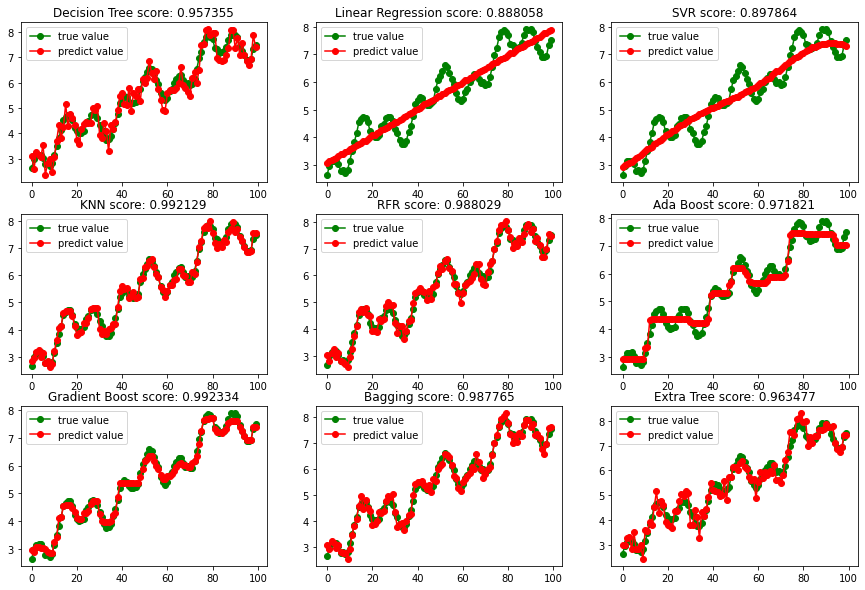

In [7]:
plt.figure(figsize=(15, 10))

for i in range(0,9):
    ax = plt.subplot(3,3,i+1)
    try_different_method(names[i],regressors[i])
    

交叉验证

将所需调参的选项至于函数最后{}中

最后打印最优参数值

并显示测试得分和测试得分标准差(样本数据方差的平方根，它衡量的是样本数据的离散)

以下以决策树和简单线性回归为例，做交叉验证

In [50]:
#导入方法
from sklearn.model_selection import GridSearchCV
import pandas as pd
class grid():
    def __init__(self,model):
        self.model = model

    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        pd.set_option('display.max_columns', None) # 显示所有列
        pd.set_option('max_colwidth',100) # 设置value的显示长度为100，默认为50
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [51]:
grid(DecisionTreeRegressor()).grid_get(x_train, y_train,{'criterion': ['mse', 'friedman_mse', 'mae'],
                                                        'splitter':['best','random']})

{'criterion': 'mse', 'splitter': 'random'} 0.8681102652722228
                                                params  mean_test_score  \
0             {'criterion': 'mse', 'splitter': 'best'}         0.897897   
1           {'criterion': 'mse', 'splitter': 'random'}         0.868110   
2    {'criterion': 'friedman_mse', 'splitter': 'best'}         0.897897   
3  {'criterion': 'friedman_mse', 'splitter': 'random'}         1.005503   
4             {'criterion': 'mae', 'splitter': 'best'}         0.897897   
5           {'criterion': 'mae', 'splitter': 'random'}         0.981244   

   std_test_score  
0        0.093354  
1        0.289245  
2        0.093354  
3        0.348604  
4        0.093354  
5        0.262745  


In [53]:
grid(LinearRegression()).grid_get(x_train, y_train,{'fit_intercept': [True, False],
                                                        'normalize':[True,False]})

{'fit_intercept': True, 'normalize': True} 0.5841868186463977
                                         params  mean_test_score  \
0    {'fit_intercept': True, 'normalize': True}         0.584187   
1   {'fit_intercept': True, 'normalize': False}         0.584464   
2   {'fit_intercept': False, 'normalize': True}         0.584423   
3  {'fit_intercept': False, 'normalize': False}         0.584423   

   std_test_score  
0        0.024039  
1        0.023935  
2        0.023859  
3        0.023859  
